In [1]:
import jax
#jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import lss_utils
import PT_field

if jax.config.jax_enable_x64:
    print("Using 64-bit precision.")
    base_dtype = jnp.float64
else:
    print("Using 32-bit precision.")
    base_dtype = jnp.float32


Using 32-bit precision.


In [2]:
boxsize = 160.0
kf = 2 * jnp.pi / boxsize
z_ic = 200.0
z_out = 2.0
OM0 = 0.31

growth = PT_field.growth_D_f(z_out, OM0)[0] / PT_field.growth_D_f(0, OM0)[0]
growth_f = PT_field.growth_D_f(z_out, OM0)[1]
print(growth, growth_f)

### Load the initial conditions and Lyman-alpha field from an appropriate source
root = '/fs52/akitsukz/accel2/160_1536'
ics_k_orig = np.load(f'{root}/ics_k_1536_z2.0.npy')
ng_orig = ics_k_orig.shape[0]
print(ng_orig)

lya_k = np.load(f'{root}/lya_k_512_z2.0.npy')

ng = 512
ng_E = lya_k.shape[0]
print('Eularian grid size:', ng_E)

ics_k = PT_field.coord_jax.func_reduce(ng, jnp.array(ics_k_orig))

### You can reduce the grid size if you want
#ng   = 128
#ng_E = 128
#ics_k = PT_field.coord_jax.func_reduce(ng, ics_k)
#lya_k = PT_field.coord_jax.func_reduce(ng_E, jnp.array(lya_k))
 


0.41854525 0.95766795
1536
Eularian grid size: 512


In [3]:
ng_L = int(1.5*ng)
print(ng, ng_L, ng_E)
window_order = 2
interlace = True

model = PT_field.LPT_Forward(boxsize=boxsize, ng_L=ng_L, ng_E=ng_E, 
                             mas_cfg=(window_order, interlace), 
                             rsd=True, lya=True, lpt_order=1,
                             dtype=base_dtype,
                             )

shifted_fields = model.get_shifted_fields(ics_k, growth_f=growth_f)
shifted_1, shifted_d, shifted_d2, shifted_G2, shifted_G2_zz, shifted_deta, shifted_eta2, shifted_KK_zz = shifted_fields

idx_to_fields = {0:'1', 1:'d', 2:'d2', 3:'G2', 4:'G2_zz', 5:'deta', 6:'eta2', 7:'KK_zz'}


512 768 512


In [4]:
k_edges = jnp.linspace(kf, 2.5, 50)
mu_edges = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

idx_to_mu = {0: r'$\mu\in [0, 0.25]$', 
             1: r'$\mu\in [0.25, 0.5]$',
             2: r'$\mu\in [0.5, 0.75]$',
             3: r'$\mu\in [0.75, 1]$',
             }

measure_pk_E = lss_utils.Measure_Pk(boxsize, ng_E, k_edges, dtype=base_dtype)

k_arr, pks_auto, Nmodes = PT_field.compute_pks_2d(shifted_fields, mu_edges, measure_pk=measure_pk_E)

#pks_auto: (n_fields, Nk, Nmu)

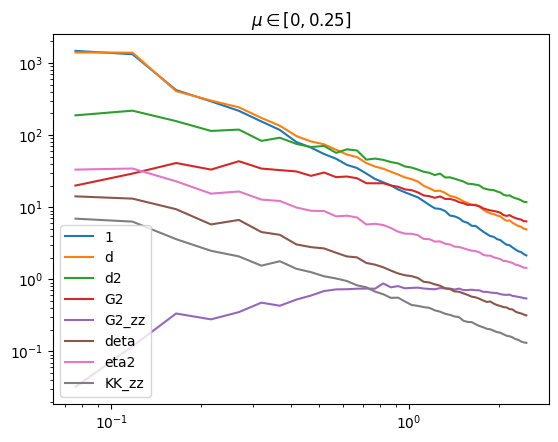

In [5]:
i_field = 0
i_mu = 0
mu = idx_to_mu[i_mu]
for i_field in range(len(shifted_fields)):
    field = idx_to_fields[i_field]
    plt.plot(k_arr, pks_auto[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [6]:
orthogonalized_fields = PT_field.orthogonalize(
    jnp.array([shifted_d, shifted_1 - 3./7.*growth_f*shifted_G2_zz, 
               shifted_d2, shifted_G2,
               shifted_deta, shifted_eta2, shifted_KK_zz]), 
               boxsize=boxsize,
               k_edges=k_edges, mu_edges=mu_edges,
               measure_pk=measure_pk_E,
               jitter=0.0,
               dtype=base_dtype,
               )

idx_to_ortho_fields = {0:'d', 1:'1', 2:'d2', 3:'G2', 4:'deta', 5:'eta2', 6:'KK_zz'}

### check orthogonalization

In [7]:
k_arr, rij = PT_field.compute_corr_2d(orthogonalized_fields, mu_edges, measure_pk=measure_pk_E)
PT_field.check_max_rij(rij)

0
01  max|r_ij| = 1.380e-06
02  max|r_ij| = 3.212e-06
03  max|r_ij| = 1.450e-05
04  max|r_ij| = 1.228e-05
05  max|r_ij| = 1.184e-05
06  max|r_ij| = 3.716e-05
12  max|r_ij| = 7.009e-05
13  max|r_ij| = 7.434e-04
14  max|r_ij| = 3.401e-04
15  max|r_ij| = 7.051e-05
16  max|r_ij| = 2.010e-04
23  max|r_ij| = 8.754e-04
24  max|r_ij| = 4.002e-04
25  max|r_ij| = 8.424e-05
26  max|r_ij| = 2.355e-04
34  max|r_ij| = 4.250e-03
35  max|r_ij| = 9.292e-04
36  max|r_ij| = 2.539e-03
45  max|r_ij| = 4.190e-04
46  max|r_ij| = 1.153e-03
56  max|r_ij| = 3.855e-04
1
01  max|r_ij| = 1.895e-06
02  max|r_ij| = 3.423e-06
03  max|r_ij| = 5.629e-05
04  max|r_ij| = 4.117e-05
05  max|r_ij| = 5.412e-05
06  max|r_ij| = 7.342e-05
12  max|r_ij| = 7.329e-05
13  max|r_ij| = 9.822e-04
14  max|r_ij| = 6.122e-04
15  max|r_ij| = 4.136e-04
16  max|r_ij| = 1.083e-03
23  max|r_ij| = 1.662e-03
24  max|r_ij| = 1.027e-03
25  max|r_ij| = 7.035e-04
26  max|r_ij| = 1.840e-03
34  max|r_ij| = 1.381e-02
35  max|r_ij| = 9.464e-03
36  max|

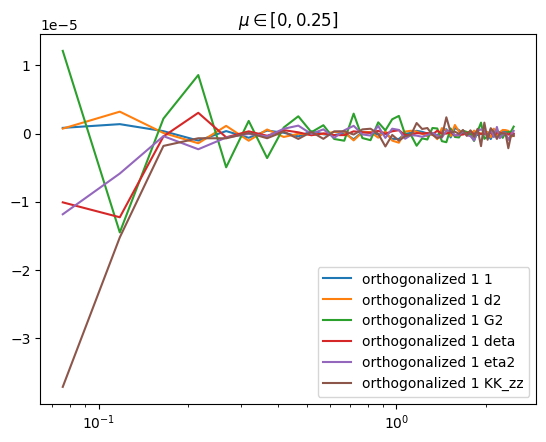

In [8]:
i_mu = 0
i_field = 0

mu = idx_to_mu[i_mu]
field_i = idx_to_fields[i_field]
for j_field in range(i_field+1, len(orthogonalized_fields)):
    field_j = idx_to_ortho_fields[j_field]
    plt.plot(k_arr, 
             rij[i_mu, i_field, j_field,:],
             label=f'orthogonalized {field_i} {field_j}')

plt.title(mu)
plt.legend()
plt.xscale('log')
#plt.yscale('log')

### Plot auto-power spectra of the orthogonalized fields

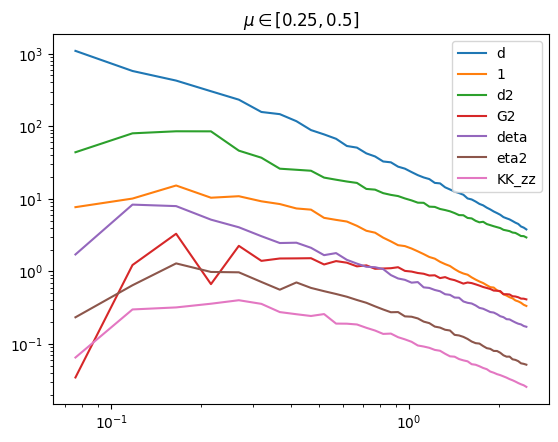

In [9]:
i_mu = 1
mu = idx_to_mu[i_mu]

k_arr, pks_auto_ortho, Nmodes = PT_field.compute_pks_2d(orthogonalized_fields, mu_edges, measure_pk=measure_pk_E)

for i_field in range(len(orthogonalized_fields)):
    field = idx_to_ortho_fields[i_field]
    plt.plot(k_arr, pks_auto_ortho[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

### compute $\beta_i(k, \mu)$ and get the final PT fields

In [10]:
beta_tab = model.get_beta(lya_k, orthogonalized_fields, 
                          mu_edges, measure_pk=measure_pk_E)

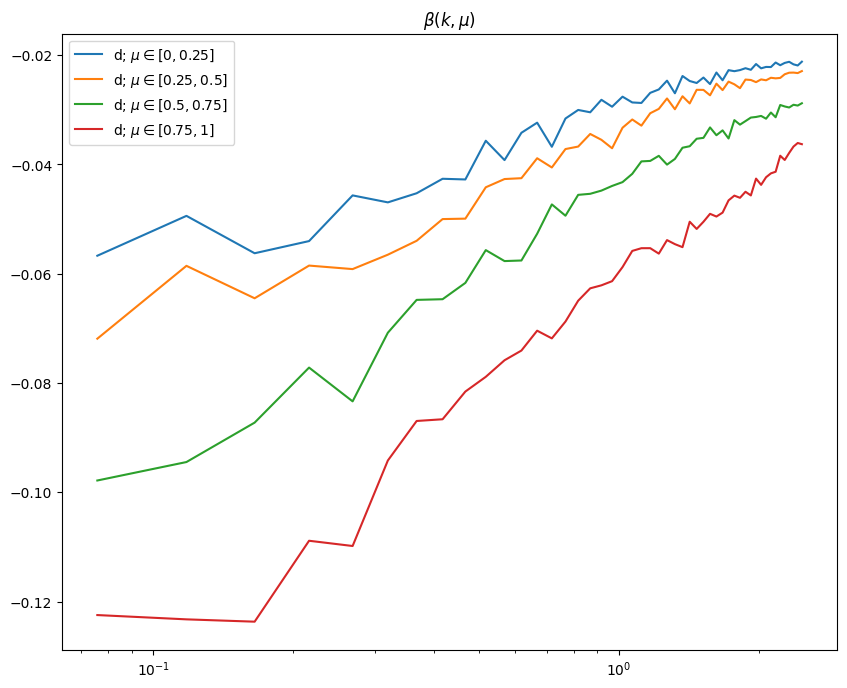

In [11]:
plt.figure(figsize=(10,8))

i_field = 0
field = idx_to_ortho_fields[i_field]

for i_mu in range(len(mu_edges)-1):
    mu = idx_to_mu[i_mu]
    plt.plot(k_arr, beta_tab[i_field,:,i_mu], 
             label=f'{field}; {mu}')

plt.title(r'$\beta(k,\mu)$')
plt.legend()
plt.xscale('log')

In [12]:
delta_g_k_linear = model.get_final_field(orthogonalized_fields[0,None],
                                         beta_tab[0,None],
                                         k_edges=k_edges, mu_edges=mu_edges,)

delta_g_k_cubic = model.get_final_field(orthogonalized_fields,
                                        beta_tab,
                                        k_edges=k_edges, mu_edges=mu_edges,)

fields = jnp.stack([lya_k, 
                    delta_g_k_linear, 
                    delta_g_k_cubic,
                    lya_k - delta_g_k_linear,
                    lya_k - delta_g_k_cubic
                    ], 
                   axis=0)

idx_to_PT_fields = {0:'LyA', 1:'linear', 2:'cubic', 3:'err; linear', 4:'err; cubic'}

k_arr, pks_auto_PT, Nmodes = PT_field.compute_pks_2d(fields, mu_edges, measure_pk=measure_pk_E)


Text(0, 0.5, '$P(k,\\mu)\\ [(\\mathrm{Mpc}/h)^3]$')

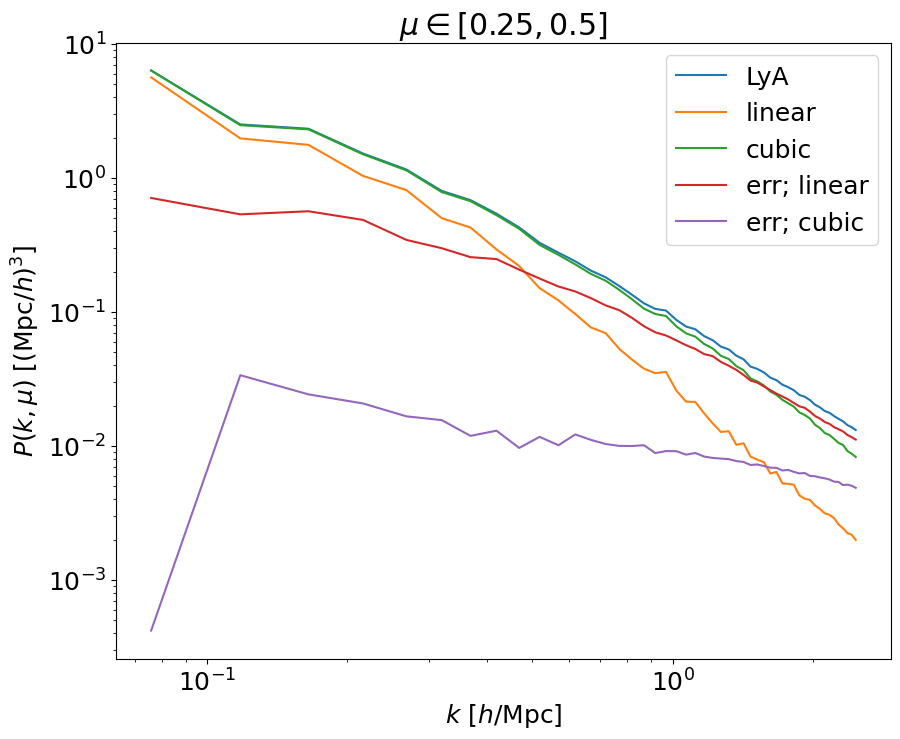

In [13]:
plt.rcParams["font.size"] = 18
plt.figure(figsize=(10,8))
i_mu = 1
mu = idx_to_mu[i_mu]

for i_field in range(len(fields)):
    field = idx_to_PT_fields[i_field]
    plt.plot(k_arr, pks_auto_PT[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k,\mu)\ [(\mathrm{Mpc}/h)^3]$')

### Get test polynomial coefficients

In [15]:
poly_k_pows  = jnp.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
poly_mu_pows = jnp.array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2])
pairwise = True
# This corresponds to 
# k^0, k^1, k^2, k^3, k^4, mu^2, k^1 mu^2, k^2 mu^2, k^3 mu^2, k^4 mu^2
#

#This is equivalent to:
#poly_k_pows  = jnp.array([0, 1, 2, 3, 4,])
#poly_mu_pows = jnp.array([0, 2,])
#pairwise = False
#This generates the all combinations of k and mu powers.

coeffs, beta_fit = PT_field.beta_polyfit(
    beta_tab,
    measure_pk=measure_pk_E,
    mu_edges=mu_edges,
    poly_k_pows=poly_k_pows,
    poly_mu_pows=poly_mu_pows,
    pairwise=pairwise,
    ridge=0.0,
    dtype=jnp.float32,
)


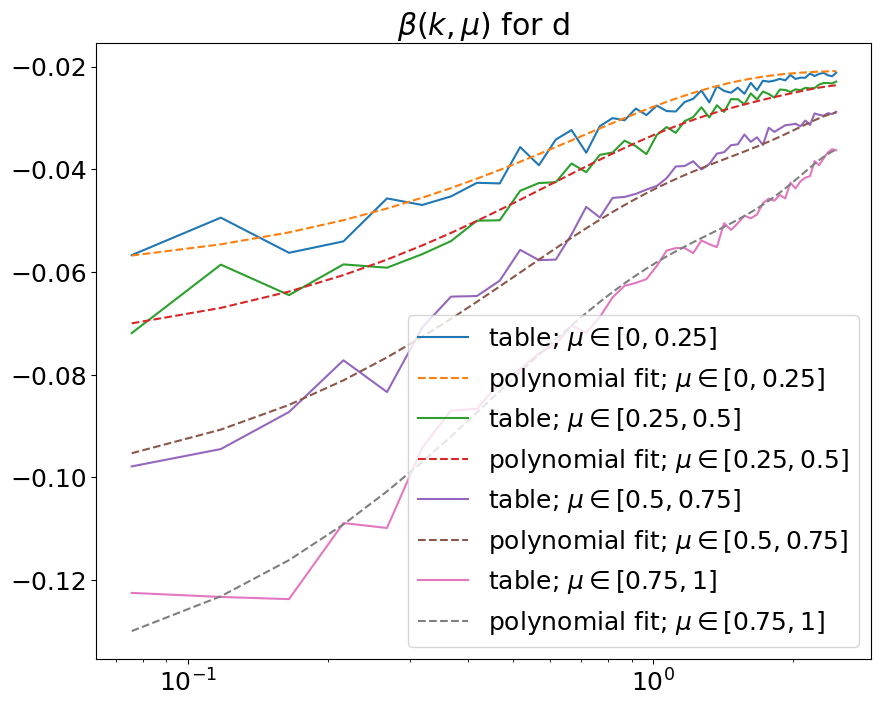

In [16]:
plt.figure(figsize=(10,8))

i_field = 0
field = idx_to_ortho_fields[i_field]

for i_mu in range(len(mu_edges)-1):
    mu = idx_to_mu[i_mu]
    plt.plot(k_arr, beta_tab[i_field,:,i_mu], 
             label=f'table; {mu}')
    plt.plot(k_arr, beta_fit[i_field,:,i_mu],
             label=f'polynomial fit; {mu}',
             linestyle='dashed')

plt.title(r'$\beta(k,\mu)$ for' +  f' {field}')
plt.legend()
plt.xscale('log')

### Generate the field given a polynomial $\beta(k,\mu) = \sum_{a,b} c^i_{a,b} k^{p_a} \mu^{2q_b}$

In [17]:
delta_g_k = model.get_final_field(orthogonalized_fields,
                                  coeffs,
                                  beta_type='poly',
                                  poly_k_pows=poly_k_pows,
                                  poly_mu_pows=poly_mu_pows,
)

fields_poly = jnp.stack([
                         delta_g_k,
                         lya_k - delta_g_k,
                         ], 
                         axis=0)

idx_to_PT_poly_fields = {0:'cubic; poly fit', 1:'err; cubic; poly fit'}

k_arr, pks_auto_PT_poly, Nmodes = PT_field.compute_pks_2d(fields_poly, mu_edges, measure_pk=measure_pk_E)

    

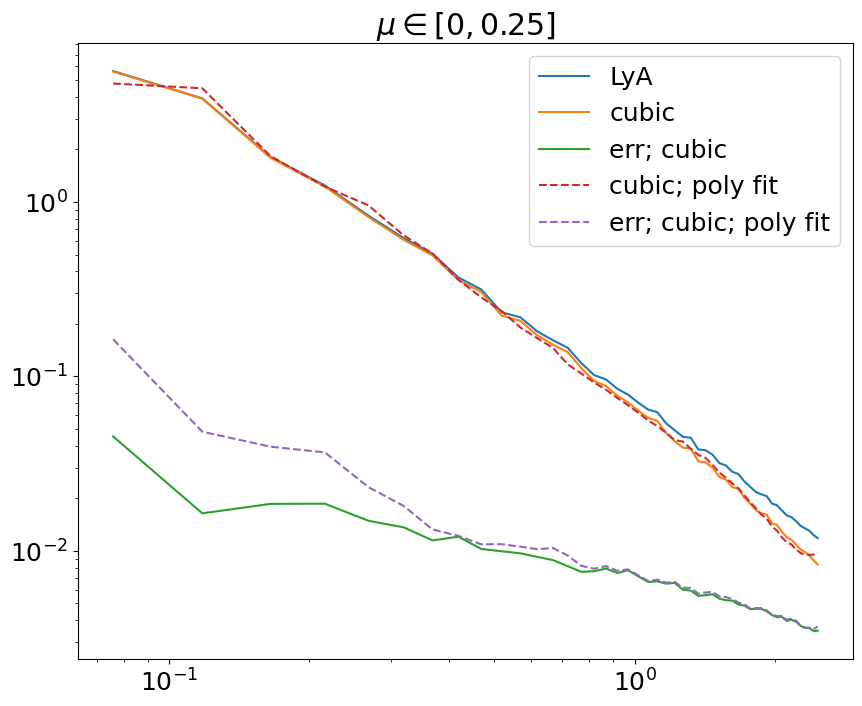

In [22]:
plt.figure(figsize=(10,8))

i_mu = 0
mu = idx_to_mu[i_mu]

for i_field in [0, 2, 4]:
    field = idx_to_PT_fields[i_field]
    plt.plot(k_arr, pks_auto_PT[i_field,:,i_mu], label=f'{field}')

for i_field in range(len(fields_poly)):
    field = idx_to_PT_poly_fields[i_field]
    plt.plot(k_arr, 
             pks_auto_PT_poly[i_field,:,i_mu], 
             linestyle='dashed',
             label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')